# Qwen Prompting with implicit class (finer-level) labels

In [1]:
import pandas as pd
from openai import OpenAI
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


### The test set we used for BERT experiment

In [2]:
test_read = pd.read_csv('clean_test.csv', delimiter=',')
print(test_read)
print()
print(len(test_read))
test_read['class'].value_counts()

                                                   post          class
0     bernie sanders : white people dont know what i...       not_hate
1       " what do we do if ? " " - antifa attacks wi...       not_hate
2                      the realist report - 9/11 debate       not_hate
3     . #alert ; #splc has posted hitlists online th...       not_hate
4     if other groups want to wine about optics and ...       not_hate
...                                                 ...            ...
4121  first isis is the jv team then they were conta...       not_hate
4122  that is false. 2nd generation immigrants from ...    inferiority
4123  racial identity  and its hostilities  are on t...       not_hate
4124  as do the younger . what generation makes up a...       not_hate
4125  pakistani sex-gang attacks covered up for fear...  stereotypical

[4126 rows x 2 columns]

4126


class
not_hate           2658
white_grievance     301
incitement          248
stereotypical       221
explicit_hate       218
inferiority         172
irony               159
threatening         133
other                16
Name: count, dtype: int64

## Classification on test examples
### Prompting with finer labels is based on the paper by Han et al.

## Exp13 - GP Finer (Classify):

General Prompt with Finer Labels & 2 major + 7 finer $\rightarrow$ mapped into 3 major  &  No definitions, no examples, no reasoning. Baseline instruction prompt 

In [19]:
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama'
)

def classify_post(post):
    try:
        prompt = f"""Classify the following comments into "white_grievance', 'incitement', 'stereotypical',
        'inferiority', 'irony', 'threatening', 'other' or 'explicit_hate', 'not_hate'.
        
Comment: {post}

Respond ONLY with ONE of these EXACT labels:

white_grievance
incitement
stereotypical
inferiority
irony
threatening
other
explicit_hate
not_hate

IMPORTANT: Your entire response must be EXACTLY ONE of these labels with no explanation, no reasoning and no additional text."""

        response = client.chat.completions.create(
            model="qwen2:7b",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
            top_p=0.0,
            max_tokens=5
        )

        raw_response = response.choices[0].message.content.strip()
        return raw_response

    except Exception as e:
        print(f"Error classifying post: {e}")
        return "error"


In [21]:
input_file = 'clean_test.csv'

df = pd.read_csv(input_file, encoding='latin1')
df['prediction'] = None

for i, row in df.iterrows():
    post = row['post']
    label = classify_post(post)
    df.at[i, 'prediction'] = label

In [22]:
output_file = 'finer_labels_clean_test_QWEN_prompt_1-2.csv'
df.to_csv(output_file, index=False, columns=['post', 'class', 'prediction'])
print(f"Results saved to {output_file}")

Results saved to finer_labels_clean_test_QWEN_prompt_1-2.csv



Number of samples: 4126
Unique true labels: ['explicit_hate', 'incitement', 'inferiority', 'irony', 'not_hate', 'other', 'stereotypical', 'threatening', 'white_grievance']
Unique predicted labels: ['explicit_hate', 'incitement', 'inferiority', 'irony', 'not_hate', 'other', 'stereotypical', 'threatening']

Classification Metrics Summary
   Metric  Macro Avg  Weighted Avg  Micro Avg
 Accuracy     0.0822        0.0822     0.0822
Precision     0.2006        0.6553     0.0822
   Recall     0.2094        0.0822     0.0822
 F1-Score     0.1020        0.0614     0.0822

Detailed Classification Report:
                 precision    recall  f1-score   support

  explicit_hate     0.1399    0.6789    0.2320       218
     incitement     0.1587    0.0806    0.1070       248
    inferiority     0.1500    0.0174    0.0312       172
          irony     0.1290    0.2013    0.1572       159
       not_hate     0.9565    0.0166    0.0325      2658
          other     0.0031    0.3750    0.0061        1

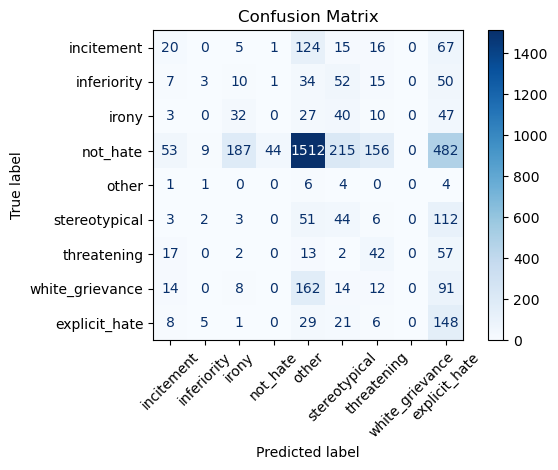

In [3]:
file_path = 'finer_labels_clean_test_QWEN_prompt_1-2.csv'  
df = pd.read_csv(file_path)

y_true = df['class']   
y_pred = df['prediction']  

print(f"\nNumber of samples: {len(y_true)}")
print(f"Unique true labels: {sorted(y_true.unique())}")
print(f"Unique predicted labels: {sorted(y_pred.unique())}")

accuracy = accuracy_score(y_true, y_pred)

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Macro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1_score(y_true, y_pred, average='macro', zero_division=0)
    ],
    'Weighted Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall_score(y_true, y_pred, average='weighted', zero_division=0),
        f1_score(y_true, y_pred, average='weighted', zero_division=0)
    ],
    'Micro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='micro', zero_division=0),
        recall_score(y_true, y_pred, average='micro', zero_division=0),
        f1_score(y_true, y_pred, average='micro', zero_division=0)
    ]
}

results_df = pd.DataFrame(metrics_data).round(4)
print("\nClassification Metrics Summary")
print("=" * 50)
print(results_df.to_string(index=False))
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

labels = [
    'incitement',
    'inferiority',
    'irony',
    'not_hate',
    'other',
    'stereotypical',
    'threatening',
    'white_grievance',
    'explicit_hate'
]

present_labels = [label for label in labels if label in y_true.unique() or label in y_pred.unique()]

if not present_labels:
    present_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))

print(f"\nUsing labels: {present_labels}")

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



Original label distribution:
True labels: class
explicit_hate       218
incitement          248
inferiority         172
irony               159
not_hate           2658
other                16
stereotypical       221
threatening         133
white_grievance     301
Name: count, dtype: int64
Predicted labels: prediction
explicit_hate    1058
incitement        126
inferiority        20
irony             248
not_hate           46
other            1958
stereotypical     407
threatening       263
Name: count, dtype: int64

New label distribution after combination:
True labels: class
explicit_hate     218
implicit_hate    1250
not_hate         2658
Name: count, dtype: int64
Predicted labels: prediction
explicit_hate    1058
implicit_hate    3022
not_hate           46
Name: count, dtype: int64

Number of samples: 4126
Unique true labels: ['explicit_hate', 'implicit_hate', 'not_hate']
Unique predicted labels: ['explicit_hate', 'implicit_hate', 'not_hate']

Classification Metrics Summary
   Metr

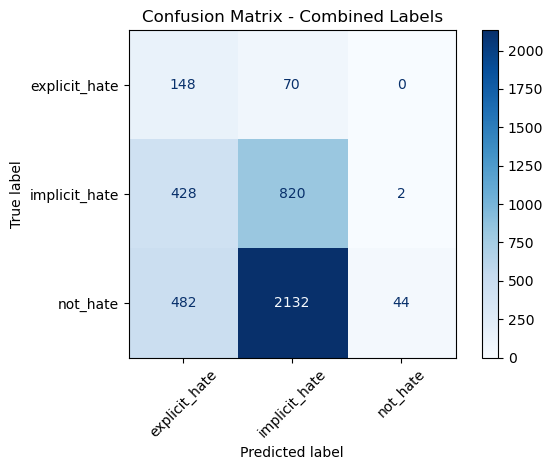

In [4]:
#Mapping into 3 classes

file_path = 'finer_labels_clean_test_QWEN_prompt_1-2.csv'  

df = pd.read_csv(file_path)
implicit_hate_labels = ['incitement', 'inferiority', 'irony', 'other', 'stereotypical', 'threatening', 'white_grievance']

def map_labels(label):
    if label in implicit_hate_labels:
        return 'implicit_hate'
    elif label == 'not_hate':
        return 'not_hate'
    elif label == 'explicit_hate':
        return 'explicit_hate'
    else:
        return 'implicit_hate'  

y_true_original = df['class']
y_pred_original = df['prediction']

y_true = y_true_original.apply(map_labels)
y_pred = y_pred_original.apply(map_labels)

print("\nOriginal label distribution:")
print("True labels:", y_true_original.value_counts().sort_index())
print("Predicted labels:", y_pred_original.value_counts().sort_index())

print("\nNew label distribution after combination:")
print("True labels:", y_true.value_counts().sort_index())
print("Predicted labels:", y_pred.value_counts().sort_index())

print(f"\nNumber of samples: {len(y_true)}")
print(f"Unique true labels: {sorted(y_true.unique())}")
print(f"Unique predicted labels: {sorted(y_pred.unique())}")

accuracy = accuracy_score(y_true, y_pred)

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Macro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1_score(y_true, y_pred, average='macro', zero_division=0)
    ],
    'Weighted Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall_score(y_true, y_pred, average='weighted', zero_division=0),
        f1_score(y_true, y_pred, average='weighted', zero_division=0)
    ],
    'Micro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='micro', zero_division=0),
        recall_score(y_true, y_pred, average='micro', zero_division=0),
        f1_score(y_true, y_pred, average='micro', zero_division=0)
    ]
}

results_df = pd.DataFrame(metrics_data).round(4)
print("\nClassification Metrics Summary")
print("=" * 50)
print(results_df.to_string(index=False))

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

final_labels = ['explicit_hate', 'implicit_hate', 'not_hate']

present_labels = [label for label in final_labels if label in y_true.unique() or label in y_pred.unique()]

if not present_labels:
    present_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))

print(f"\nUsing labels: {present_labels}")

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Combined Labels")
plt.tight_layout()
plt.show()

df_updated = df.copy()
df_updated['class_combined'] = y_true
df_updated['prediction_combined'] = y_pred


## Exp12 - GP + (Consider Finer):

General Prompt with Finer Labels  & 2 major + 7 finer $\rightarrow$ mapped into 3 major. No definitions, no examples, no reasoning. Baseline instruction prompt + "For implicit class consider" finer classes. 

In [6]:
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama'
)

def classify_post(post):
    try:
        prompt = f"""Classify the following comments into ’explicit_hate’, 'implicit_hate' or ’not_hate’. For ’implicit_hate’ consider if it is 'white_grievance', 'incitement', 'stereotypical',
        'inferiority', 'irony', 'threatening', 'other'.
        
Comment: {post}

Respond ONLY with ONE of these EXACT labels:

explicit_hate
white_grievance
incitement
stereotypical
inferiority
irony
threatening
other
not_hate

IMPORTANT: Your entire response must be EXACTLY ONE of these labels with no explanation, no reasoning and no additional text."""

        response = client.chat.completions.create(
            model="qwen2:7b",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,
            top_p=0.0,
            max_tokens=5
        )

        raw_response = response.choices[0].message.content.strip()
        return raw_response

    except Exception as e:
        print(f"Error classifying post: {e}")
        return "error"


In [19]:
input_file = 'finer_labels_data/clean_test.csv'
df = pd.read_csv(input_file, encoding='latin1')
df['prediction'] = None


for i, row in df.iterrows():
    post = row['post']
    label = classify_post(post)
    df.at[i, 'prediction'] = label

In [20]:
output_file = 'finer_labels_data/finer_labels_clean_test_QWEN_prompt_3.csv'
df.to_csv(output_file, index=False, columns=['post', 'class', 'prediction'])
print(f"Results saved to {output_file}")

Results saved to finer_labels_data/finer_labels_clean_test_QWEN_prompt_3.csv



Number of samples: 4126
Unique true labels: ['explicit_hate', 'incitement', 'inferiority', 'irony', 'not_hate', 'other', 'stereotypical', 'threatening', 'white_grievance']
Unique predicted labels: ['explicit_hate', 'incitement', 'inferiority', 'irony', 'not_hate', 'other', 'stereotypical', 'threatening']

Classification Metrics Summary
   Metric  Macro Avg  Weighted Avg  Micro Avg
 Accuracy     0.1580        0.1580      0.158
Precision     0.2101        0.6620      0.158
   Recall     0.1829        0.1580      0.158
 F1-Score     0.1009        0.1975      0.158

Detailed Classification Report:
                 precision    recall  f1-score   support

  explicit_hate     0.1226    0.8532    0.2144       218
     incitement     0.1163    0.1008    0.1080       248
    inferiority     0.2759    0.0465    0.0796       172
          irony     0.2500    0.0692    0.1084       159
       not_hate     0.9636    0.1494    0.2586      2658
          other     0.0030    0.3125    0.0060        1

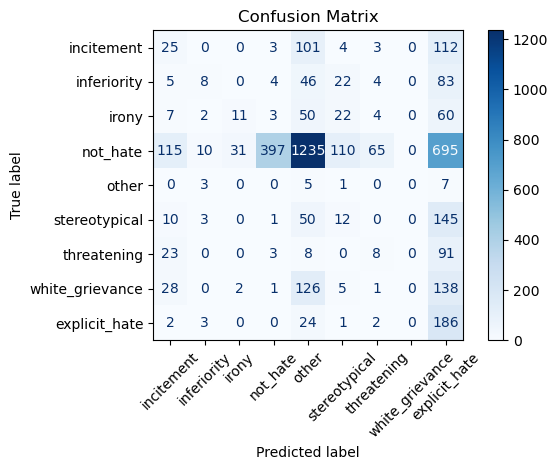


Results saved to: classification_results.csv


In [5]:
file_path = 'finer_labels_data/finer_labels_clean_test_QWEN_prompt_3.csv'  
df = pd.read_csv(file_path)

y_true = df['class']  
y_pred = df['prediction']   

print(f"\nNumber of samples: {len(y_true)}")
print(f"Unique true labels: {sorted(y_true.unique())}")
print(f"Unique predicted labels: {sorted(y_pred.unique())}")

accuracy = accuracy_score(y_true, y_pred)

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Macro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1_score(y_true, y_pred, average='macro', zero_division=0)
    ],
    'Weighted Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall_score(y_true, y_pred, average='weighted', zero_division=0),
        f1_score(y_true, y_pred, average='weighted', zero_division=0)
    ],
    'Micro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='micro', zero_division=0),
        recall_score(y_true, y_pred, average='micro', zero_division=0),
        f1_score(y_true, y_pred, average='micro', zero_division=0)
    ]
}

results_df = pd.DataFrame(metrics_data).round(4)
print("\nClassification Metrics Summary")
print("=" * 50)
print(results_df.to_string(index=False))

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

labels = [
    'incitement',
    'inferiority',
    'irony',
    'not_hate',
    'other',
    'stereotypical',
    'threatening',
    'white_grievance',
    'explicit_hate'
]

present_labels = [label for label in labels if label in y_true.unique() or label in y_pred.unique()]

if not present_labels:
    present_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))

print(f"\nUsing labels: {present_labels}")

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

output_file = 'classification_results.csv'
results_df.to_csv(output_file, index=False)
print(f"\nResults saved to: {output_file}")


Original label distribution:
True labels: class
explicit_hate       218
incitement          248
inferiority         172
irony               159
not_hate           2658
other                16
stereotypical       221
threatening         133
white_grievance     301
Name: count, dtype: int64
Predicted labels: prediction
explicit_hate    1517
incitement        215
inferiority        29
irony              44
not_hate          412
other            1645
stereotypical     177
threatening        87
Name: count, dtype: int64

New label distribution after combination:
True labels: class
explicit_hate     218
implicit_hate    1250
not_hate         2658
Name: count, dtype: int64
Predicted labels: prediction
explicit_hate    1517
implicit_hate    2197
not_hate          412
Name: count, dtype: int64

Number of samples: 4126
Unique true labels: ['explicit_hate', 'implicit_hate', 'not_hate']
Unique predicted labels: ['explicit_hate', 'implicit_hate', 'not_hate']

Classification Metrics Summary
   Metr

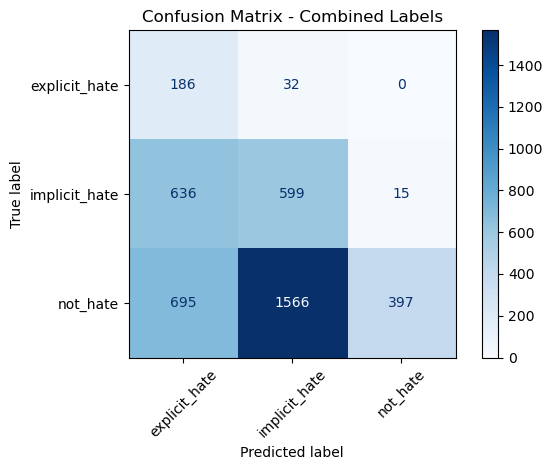

In [6]:
#Mapping into 3 classes

file_path = 'finer_labels_data/finer_labels_clean_test_QWEN_prompt_3.csv'  

df = pd.read_csv(file_path)
implicit_hate_labels = ['incitement', 'inferiority', 'irony', 'other', 'stereotypical', 'threatening', 'white_grievance']

def map_labels(label):
    if label in implicit_hate_labels:
        return 'implicit_hate'
    elif label == 'not_hate':
        return 'not_hate'
    elif label == 'explicit_hate':
        return 'explicit_hate'
    else:
        return 'implicit_hate'  

y_true_original = df['class']
y_pred_original = df['prediction']

y_true = y_true_original.apply(map_labels)
y_pred = y_pred_original.apply(map_labels)

print("\nOriginal label distribution:")
print("True labels:", y_true_original.value_counts().sort_index())
print("Predicted labels:", y_pred_original.value_counts().sort_index())

print("\nNew label distribution after combination:")
print("True labels:", y_true.value_counts().sort_index())
print("Predicted labels:", y_pred.value_counts().sort_index())

print(f"\nNumber of samples: {len(y_true)}")
print(f"Unique true labels: {sorted(y_true.unique())}")
print(f"Unique predicted labels: {sorted(y_pred.unique())}")

accuracy = accuracy_score(y_true, y_pred)

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Macro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='macro', zero_division=0),
        recall_score(y_true, y_pred, average='macro', zero_division=0),
        f1_score(y_true, y_pred, average='macro', zero_division=0)
    ],
    'Weighted Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall_score(y_true, y_pred, average='weighted', zero_division=0),
        f1_score(y_true, y_pred, average='weighted', zero_division=0)
    ],
    'Micro Avg': [
        accuracy,
        precision_score(y_true, y_pred, average='micro', zero_division=0),
        recall_score(y_true, y_pred, average='micro', zero_division=0),
        f1_score(y_true, y_pred, average='micro', zero_division=0)
    ]
}

results_df = pd.DataFrame(metrics_data).round(4)
print("\nClassification Metrics Summary")
print("=" * 50)
print(results_df.to_string(index=False))

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0, digits=4))

final_labels = ['explicit_hate', 'implicit_hate', 'not_hate']

present_labels = [label for label in final_labels if label in y_true.unique() or label in y_pred.unique()]

if not present_labels:
    present_labels = sorted(list(set(y_true.unique()) | set(y_pred.unique())))

print(f"\nUsing labels: {present_labels}")

cm = confusion_matrix(y_true, y_pred, labels=present_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Combined Labels")
plt.tight_layout()
plt.show()

df_updated = df.copy()
df_updated['class_combined'] = y_true
df_updated['prediction_combined'] = y_pred
